# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#  !pip3 install mpld3
import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys

In [3]:
from Cluster import * 

Getting data:
getting JHU data...
expanding JHU data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
expansion done.
number of countries listed 274
done with JHU data (covid_ts dictionary keys: confirmed, deaths, recovered).  Got  274 countries (countries_jhu).
getting owid data...
expanding OWID data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
done with OWID data (covid_owid_ts dictionary see .keys()) . Got 212 countries (countries_owid)
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------
Constructing common synchronized deaths, case and testing data...
database JHU correct active True
done.
doing piecwise linear fits to testing data ...
done.
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default
----------

In [4]:
from model_fits import *  # including ModelFit class definition.

loading data.py...
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [5]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in countries_common if population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in countries_common if population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


186 countries with population data
common countries without population data []
67 cluster countries


In [6]:
[x for x in covid_ts]

['confirmed',
 'deaths',
 'recovered',
 'new_deaths',
 'new_deaths_smoothed',
 'deaths_smoothed',
 'new_deaths_corrected',
 'new_deaths_corrected_smoothed',
 'deaths_corrected_smoothed',
 'new_confirmed',
 'new_confirmed_smoothed',
 'confirmed_smoothed',
 'new_confirmed_corrected',
 'new_confirmed_corrected_smoothed',
 'confirmed_corrected_smoothed',
 'new_recovered',
 'new_recovered_smoothed',
 'recovered_smoothed',
 'new_recovered_corrected',
 'new_recovered_corrected_smoothed',
 'recovered_corrected_smoothed']

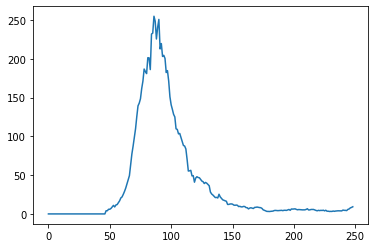

In [12]:
plt.plot(covid_ts['new_deaths_corrected_smoothed'][('Germany','')])

# Curve Fitting Example

We want to fit the following curve:

In [6]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

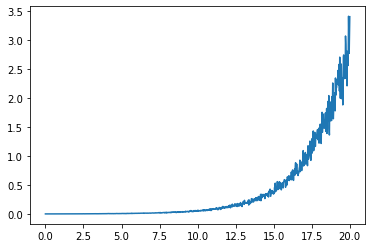

In [7]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [8]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [9]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [10]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

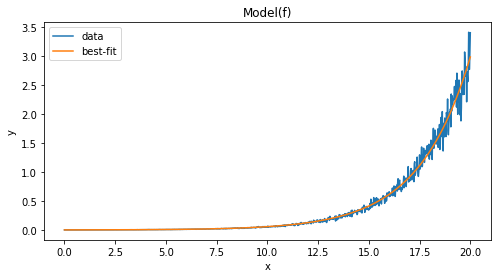

In [11]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [12]:
result

# Use ModelFit class

In [13]:
#  file containing only ModelFit class, 
#exec(open('ModelFit.py','r').read())

In [13]:
testfit = ModelFit('SC3EI3R',country='Germany',run_id="_tst_J")

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst_J.pk


In [14]:
foo = testfit.solvefit() # default target is 'deaths' with 'deaths_corrected_smoothed' fitting data

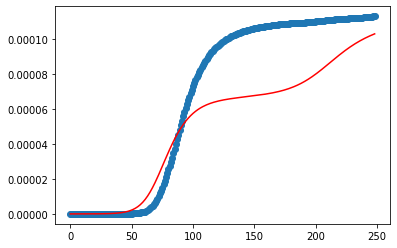

In [15]:
dat = foo['deaths']['data']
plt.plot(range(len(dat)),dat,'o')
plt.plot(foo['deaths']['soln'],color='red');

# Use `Modelfit.solvefit()` with `lmfit`

In [26]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [27]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,new=True,run_id="_testx")

In [28]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.07, 0.0, 0.5),
                   "c_2": (5000, 0.,20000), 
                    "logI_0": (-6.,-10.,0.0)}

In [29]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.09999999999999998,
 'c_0': 0.1,
 'c_1': 0.015,
 'c_2': 10000.0,
 'N': 1}

In [40]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder')

elapsed time =  29.664251804351807
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1369
    # data points      = 249
    # variables        = 6
    chi-square         = 1.0222e-11
    reduced chi-square = 4.2065e-14
    Akaike info crit   = -7663.16255
    Bayesian info crit = -7642.05783
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.53520432 +/-        nan (nan%) (init = 0.2)
    mu:      0.09908734 +/-        nan (nan%) (init = 0.1)
    c_0:     0.23468638 +/-        nan (nan%) (init = 0.1)
    c_1:     0.00422274 +/- 1.4816e-05 (0.35%) (init = 0.07)
    c_2:     13485.7049 +/-        nan (nan%) (init = 5000)
    logI_0: -8.21556404 +/-        nan (nan%) (init = -6)


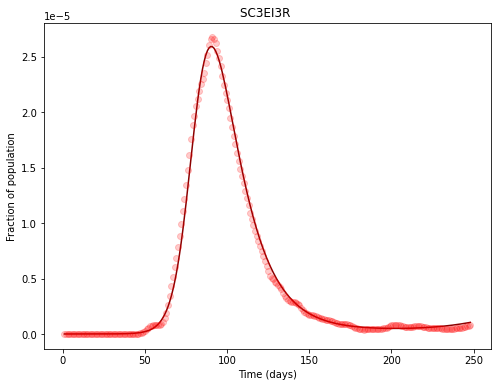

In [41]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

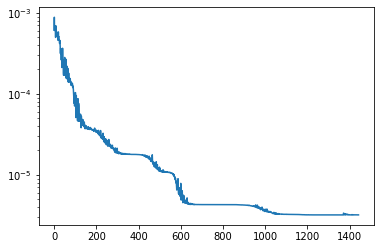

In [42]:
plt.semilogy(MyModel.residall);

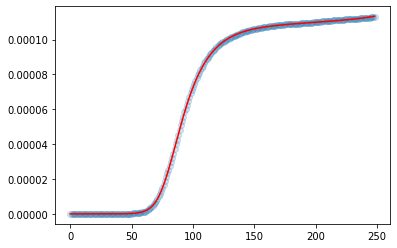

In [43]:
foo = MyModel.solvefit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [44]:
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

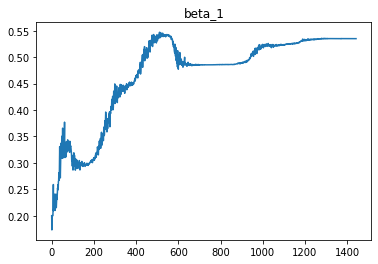

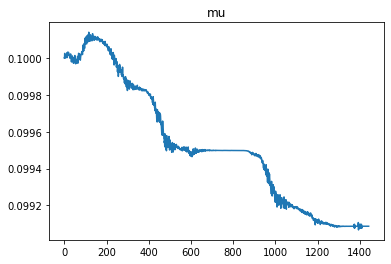

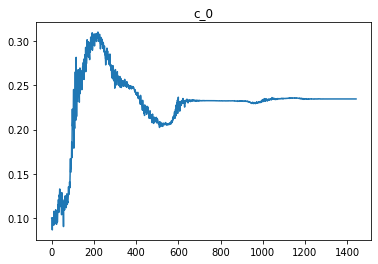

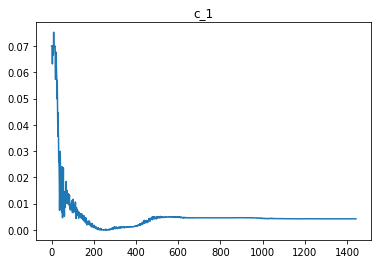

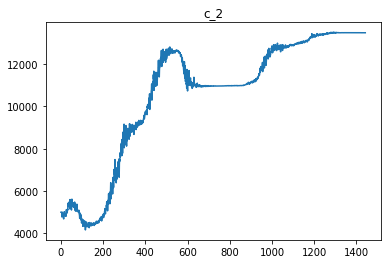

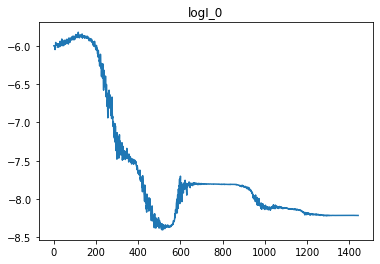

In [45]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [39]:
[MyModel.params_lmf[x] for x in MyModel.params_lmf]

[<Parameter 'beta_1', value=0.2, bounds=[0.0:2.0]>,
 <Parameter 'mu', value=0.1, bounds=[0.0:0.2]>,
 <Parameter 'c_0', value=0.1, bounds=[0.0:1.0]>,
 <Parameter 'c_1', value=0.07, bounds=[0.0:0.5]>,
 <Parameter 'c_2', value=5000, bounds=[0.0:20000]>,
 <Parameter 'logI_0', value=-6.0, bounds=[-10.0:0.0]>]

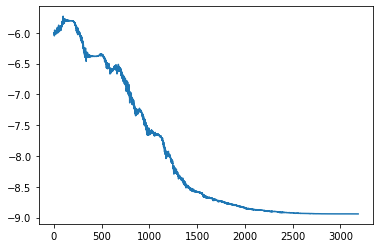

In [43]:
p0 = [x[pars[5]] for x in paramsall]
plt.plot(p0);

In [31]:
outfit.params

name,value,initial value,min,max,vary
beta_1,0.57899685,0.2,0.00000000,2.00000000,True
mu,0.09781034,0.1,0.00000000,0.20000000,True
c_0,0.22590755,0.1,0.00000000,1.00000000,True
c_1,0.00410705,0.07,0.00000000,0.50000000,True
c_2,15340.9023,5000,0.00000000,20000.0000,True
logI_0,-8.34128415,-6.0,-10.0000000,0.00000000,True


## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* chose nelder, because of consistent gradual convergence.

## USA

In [152]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [166]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2")

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test2.pk


In [167]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.07, 0.0, 0.5),
                   "c_2": (5000, 0.,20000), 
                    "logI_0": (-6.,-10.,0.0)}

In [168]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.09999999999999998,
 'c_0': 0.1,
 'c_1': 0.015,
 'c_2': 10000.0,
 'N': 1}

In [169]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max)

elapsed time =  4.4120073318481445
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 176
    # data points      = 249
    # variables        = 6
    chi-square         = 2.2210e-09
    reduced chi-square = 9.1397e-12
    Akaike info crit   = -6323.25222
    Bayesian info crit = -6302.14751
[[Variables]]
    beta_1:  0.36060228 +/- 0.00709228 (1.97%) (init = 0.2)
    mu:      0.13747366 +/- 0.00383843 (2.79%) (init = 0.1)
    c_0:     0.25140649 +/- 0.00453234 (1.80%) (init = 0.1)
    c_1:     0.03516262 +/- 0.00127254 (3.62%) (init = 0.07)
    c_2:     3739.66031 +/- 122.500708 (3.28%) (init = 5000)
    logI_0: -6.45573009 +/- 0.06801028 (1.05%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.989
    C(c_2, logI_0)    = -0.892
    C(beta_1, c_2)    =  0.883
    C(beta_1, c_1)    =  0.851
    C(mu, c_1)        = -0.830
    C(c_1, logI_0)    = -0.791
    C(beta_1, mu)     = -0.721
    C(c_1, c_2)       =  0.650
    

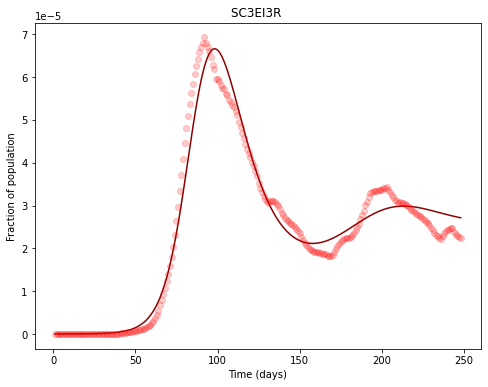

In [170]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

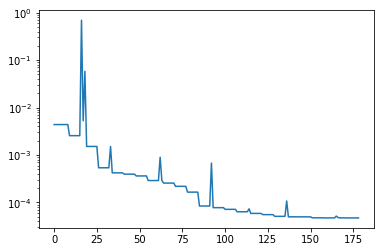

In [171]:
plt.semilogy(MyModel.residall);

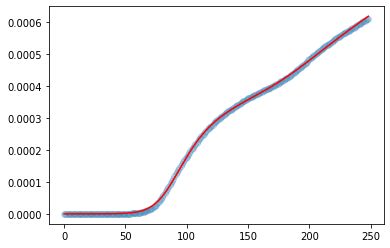

In [172]:
foo = MyModel.solvefit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

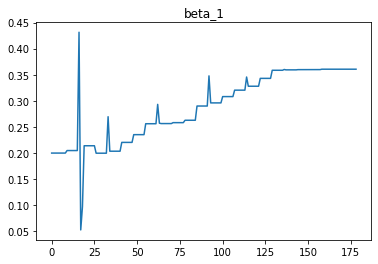

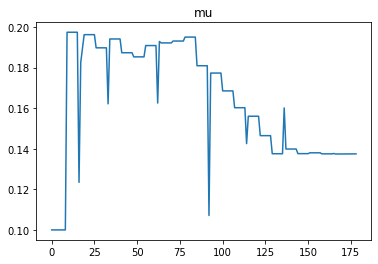

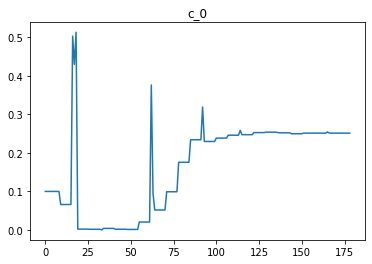

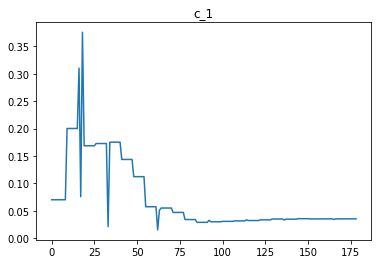

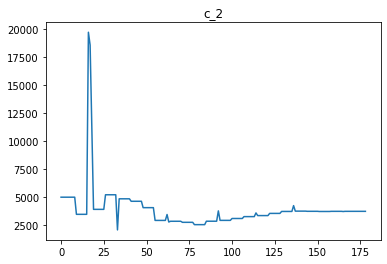

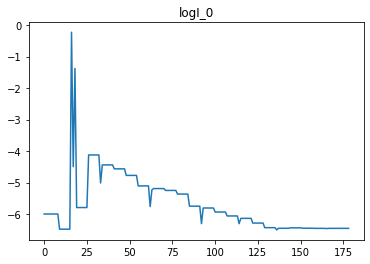

In [173]:
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

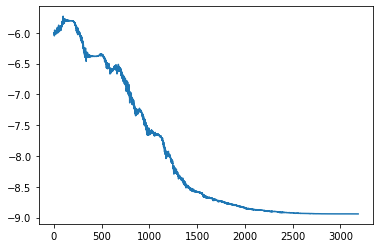

In [43]:
p0 = [x[pars[5]] for x in paramsall]
plt.plot(p0);

In [174]:
MyModel.params

{'beta_1': 0.36060228043845544,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.13747366197802635,
 'c_0': 0.2514064893425837,
 'c_1': 0.035162615879887005,
 'c_2': 3739.660310095638,
 'N': 1}

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany

In [10]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [176]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk :


In [177]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.07, 0.0, 0.5),
                   "c_2": (5000, 0.,20000), 
                    "logI_0": (-6.,-10.,0.0)}

In [178]:
MyModel.params

{'beta_1': 0.33043220637267523,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.10605761433406191,
 'c_0': 0.1024052929006089,
 'c_1': 0.007152663949729021,
 'c_2': 4332.1787869056825,
 'N': 1}

In [179]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder')

elapsed time =  22.288007974624634
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1369
    # data points      = 249
    # variables        = 6
    chi-square         = 1.0222e-11
    reduced chi-square = 4.2065e-14
    Akaike info crit   = -7663.16255
    Bayesian info crit = -7642.05783
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.53520432 +/-        nan (nan%) (init = 0.2)
    mu:      0.09908734 +/-        nan (nan%) (init = 0.1)
    c_0:     0.23468638 +/-        nan (nan%) (init = 0.1)
    c_1:     0.00422274 +/- 1.4816e-05 (0.35%) (init = 0.07)
    c_2:     13485.7049 +/-        nan (nan%) (init = 5000)
    logI_0: -8.21556404 +/-        nan (nan%) (init = -6)


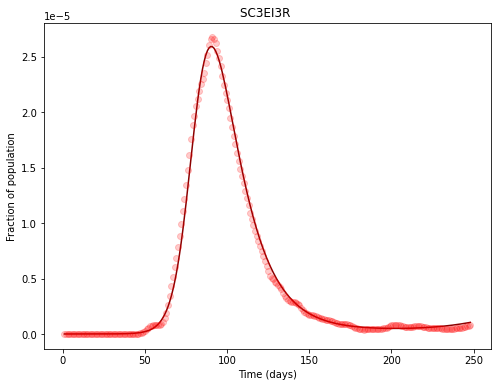

In [181]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

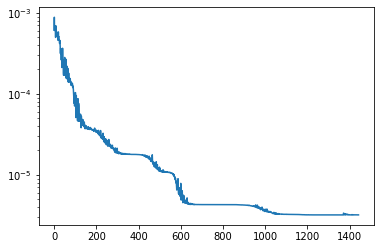

In [182]:
plt.semilogy(MyModel.residall);

### Country scan

In [7]:
countries[0]

'Afghanistan'

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan") # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False)
        MyModel.solveplot(species=['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Afghanistan_scan.pk :
Problem...
<class 'NameError'>
name 'MyModel' is not defined
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Albania_scan.pk :
Problem...
<class 'NameError'>
name 'MyModel' is not defined
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Algeria_scan.pk :
Problem...
<class 'NameError'>
name 'MyModel' is not defined
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Andorra_scan.pk :
Problem...
<class 'NameError'>
name 'MyModel' is not defined
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Angola_scan.pk :
Problem...
<class 'NameError'>
name 'MyModel' is not defined
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Antigua and Barbuda_scan.pk :
Pr

## Try for U model class

From Caution_paper_Fitting notebook:
```    
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
```

In [168]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_United States_test.pk :


In [169]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [170]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

beta_1 0.29 (0.2, 0.0, 2.0)
mu 0.10020082608068095 (0.1, 0.0, 0.2)
c_0 0.0660998825694582 (0.1, 0.0, 1.0)
c_1 0.036352803085880125 (0.07, 0.0, 0.5)
c_2 5613.480446603666 (5000, 0.0, 20000)
k_u 0.1873706480911983 (0.2, 0, 1)
k_1 0.0027054700168432366 (0.011111111111111112, 0.0, 1.0)
k_w 0.005333507965541995 (0.011111111111111112, 0.0, 1.0)


In [171]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max)

elapsed time =  27.693687200546265
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 675
    # data points      = 272
    # variables        = 9
    chi-square         = 8.5679e-08
    reduced chi-square = 3.2577e-10
    Akaike info crit   = -5932.94187
    Bayesian info crit = -5900.48965
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.29104292 (init = 0.2)
    mu:      0.10020083 (init = 0.1)
    c_0:     0.06609988 (init = 0.1)
    c_1:     0.03635280 (init = 0.07)
    c_2:     5613.48045 (init = 5000)
    k_u:     0.18737065 (init = 0.2)
    k_1:     0.00270547 (init = 0.01111111)
    k_w:     0.00533351 (init = 0.01111111)
    logI_0: -6.17497782 (init = -6)


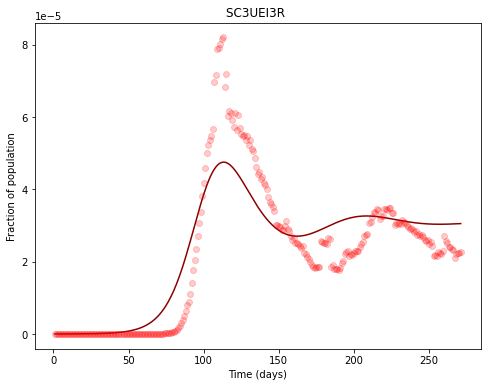

In [172]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

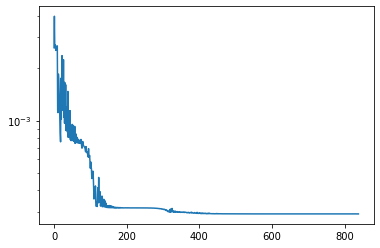

In [173]:
plt.semilogy(MyModel.residall);

In [174]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq')

elapsed time =  8.95629596710205
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 350
    # data points      = 272
    # variables        = 9
    chi-square         = 2.0165e-09
    reduced chi-square = 7.6672e-12
    Akaike info crit   = -6952.73893
    Bayesian info crit = -6920.28671
##  Warning: uncertainties could not be estimated:
    k_w:     at initial value
[[Variables]]
    beta_1:  0.43120580 (init = 0.2)
    mu:      0.05644585 (init = 0.1)
    c_0:     0.10620367 (init = 0.1)
    c_1:     8.3198e-04 (init = 0.07)
    c_2:     4868.54503 (init = 5000)
    k_u:     0.25740638 (init = 0.2)
    k_1:     0.00476825 (init = 0.01111111)
    k_w:     0.01111111 (init = 0.01111111)
    logI_0: -8.21463436 (init = -6)


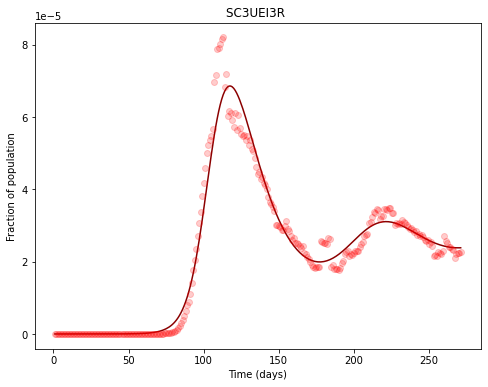

In [175]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

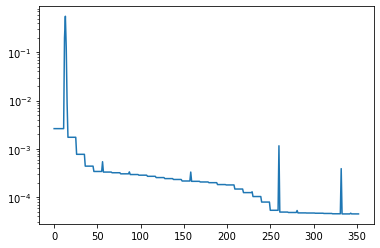

In [176]:
plt.semilogy(MyModel.residall);

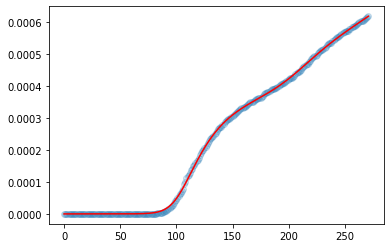

In [177]:
foo = MyModel.solvefit('deaths')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

### slider plot

In [131]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [132]:
def slidefitplot(beta_1):
    MyModel.set_param('beta_1',beta_1)
    MyModel.solveplot(species=['deaths'],figsize = (15,15))

In [134]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=MyModel.params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f')
             )
display(w)

interactive(children=(FloatSlider(value=0.29104292482815264, continuous_update=False, description='beta_1', la…

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [148]:
def foo(**kwargs):
    for x in kwargs:
        print(x,'\t',kwargs[x])

In [146]:
foo(a=1,b=2,c=4,d=6)

a 	 1
b 	 2
c 	 4
d 	 6


### Country scan

In [182]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

70

In [11]:
MyModel = ModelFit('SC3UEI3R',country=countries[0],run_id="_scan")

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Afghanistan_scan.pk


In [12]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [13]:
MyModel.fit(params_init_min_max,diag=False)

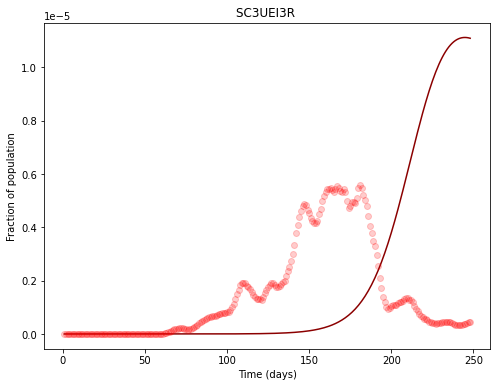

In [14]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Afghanistan_scan.pk :
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Albania_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Algeria_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Andorra_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Angola_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Antigua and Barbuda_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Argentina_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Armenia_scan.pk
F

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Guinea-Bissau_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Guyana_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Haiti_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Vatican_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Honduras_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Hungary_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Iceland_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_India_scan.pk
For th

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Russia_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Rwanda_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Saint Kitts and Nevis_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Saint Lucia_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Saint Vincent and the Grenadines_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_San Marino_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Sao Tome and Principe_scan.pk
For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks

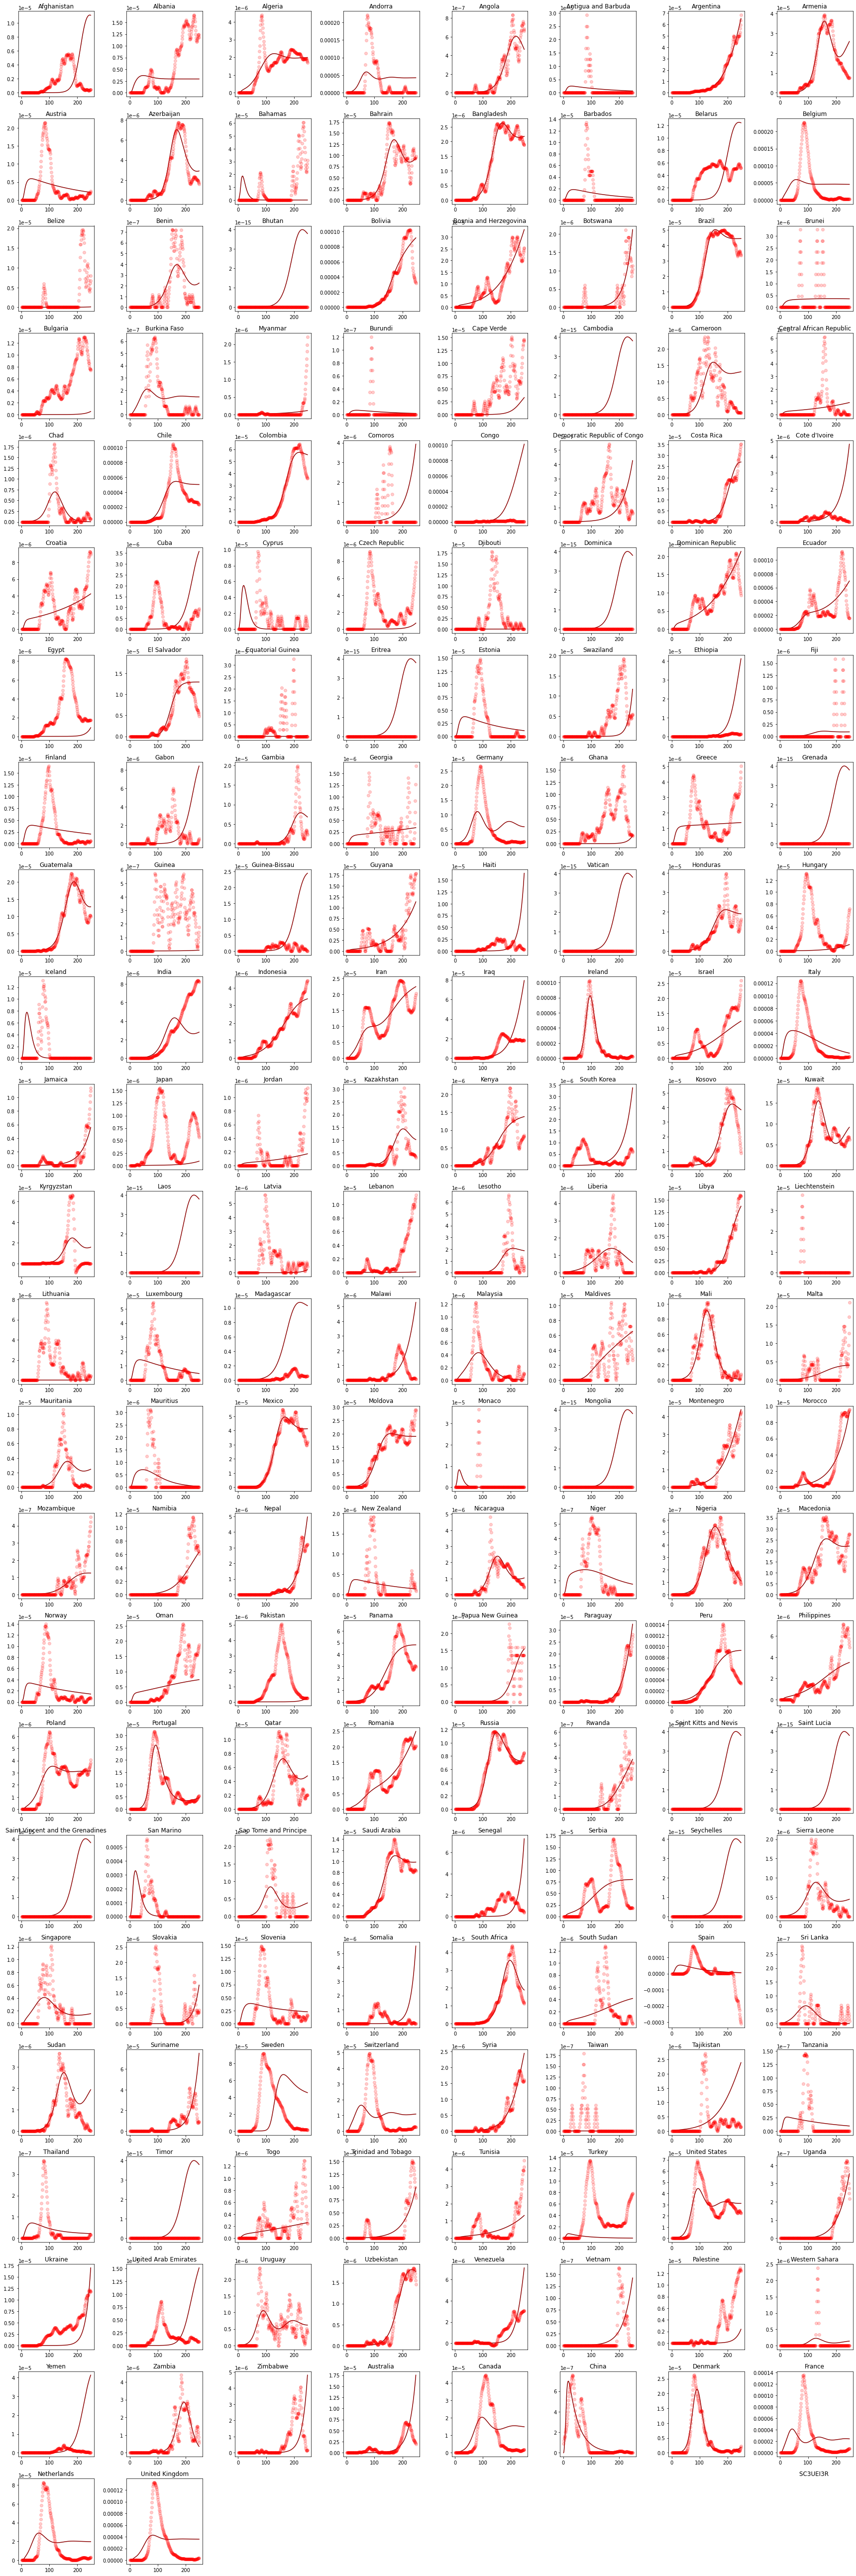

In [15]:
cnt=0
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan") # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False)
        MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()